## <b><font color='darkblue'>Preface</font></b>
([course source](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/7/essay-writer))

In [1]:
!pip freeze | grep -P '(openai|langchain|langgraph)'

langchain==0.2.6
langchain-anthropic==0.1.15
langchain-community==0.2.6
langchain-core==0.2.10
langchain-experimental==0.0.62
langchain-google-genai==1.0.6
langchain-groq==0.1.3
langchain-openai==0.1.9
langchain-text-splitters==0.2.0
langchainhub==0.1.14
langgraph==0.1.4
openai==1.28.1


In [12]:
import os
import openai
import re
import httpx
import os
from tavily import TavilyClient
from dotenv import load_dotenv, find_dotenv

from openai import OpenAI
from langchain_openai import ChatOpenAI

a = load_dotenv(find_dotenv(os.path.expanduser('~/.env'))) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

# connect
tavily = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [5]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [11]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [4]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

## <b><font color='darkblue'>Agent prompts</font></b>

In [6]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [7]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [8]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [9]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""

In [10]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""

## <b><font color='darkblue'>Agent nodes</font></b>

In [13]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [14]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [15]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

In [16]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [17]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [18]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

## <b><font color='darkblue'>Building Graph</font></b>

In [19]:
builder = StateGraph(AgentState)

In [20]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [21]:
builder.set_entry_point("planner")

In [22]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)

In [23]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [24]:
graph = builder.compile(checkpointer=memory)

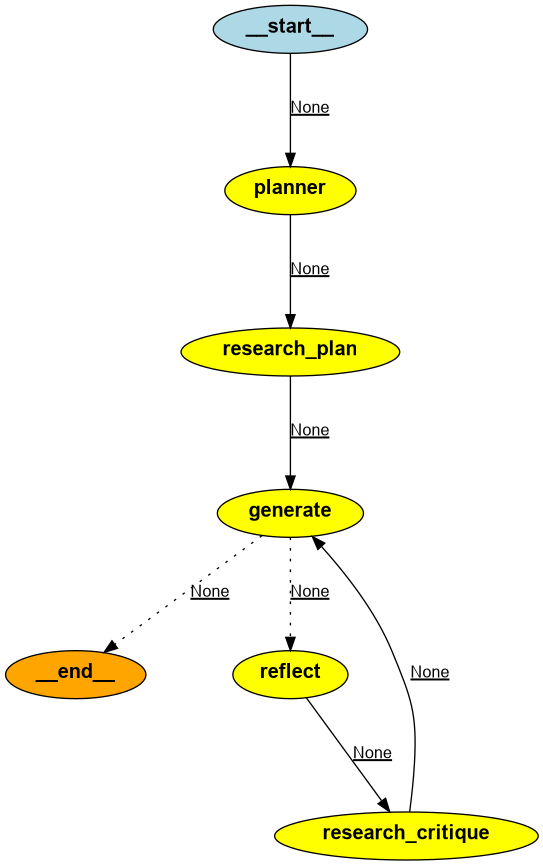

In [25]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

## <b><font color='darkblue'>Start writting essay</font></b>

In [29]:
thread = {"configurable": {"thread_id": "1"}}
session_list = []
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    step = list(s.keys())[0]
    content = ''
    if step == 'planner':
        content = s[step]['plan']
    elif step == 'research_plan':
        content = s[step]['content']
    elif step == 'generate':
        content = s[step]['draft']
    elif step == 'reflect':
        content = s[step]['critique']
    elif step == 'research_critique':
        content = s[step]['content']
    print(f'{step}:\n{content}\n\n')
    session_list.append(s)

planner:
I. Introduction
    A. Brief overview of Langchain and Langsmith
    B. Thesis statement: Exploring the differences between Langchain and Langsmith

II. Langchain
    A. Definition and purpose
    B. Key features and characteristics
    C. Use cases and applications
    D. Advantages and limitations

III. Langsmith
    A. Definition and purpose
    B. Key features and characteristics
    C. Use cases and applications
    D. Advantages and limitations

IV. Comparison between Langchain and Langsmith
    A. Technology stack
    B. Scalability and performance
    C. Security and privacy
    D. Adoption and popularity
    E. Future prospects

V. Conclusion
    A. Recap of key differences between Langchain and Langsmith
    B. Implications for the future of blockchain technology
    C. Final thoughts and recommendations

Notes:
- Ensure to provide clear definitions and examples for both Langchain and Langsmith.
- Use specific examples and case studies to illustrate the differences b

## <b><font color='darkblue'>Essay Writer Interface</font></b>

In [28]:
#import warnings
#warnings.filterwarnings("ignore")

#from helper import ewriter, writer_gui

#MultiAgent = ewriter()
#app = writer_gui(MultiAgent.graph)
#app.launch()

## <b><font color='darkblue'>Supplement</font></b>
* [Deeplearn.ai - AI Agents in LangGraph - Ch2: Build an Agent from Scratch](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/2/build-an-agent-from-scratch)
* [Deeplearn.ai - AI Agents in LangGraph - Ch3: LangGraph components](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/3/langgraph-components)
* [Deeplearn.ai - AI Agents in LangGraph - Ch4: Agentic search tools](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/4/agentic-search-tools)
* [Deeplearn.ai - AI Agents in LangGraph - Ch5: Persistence and streaming](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/5/persistence-and-streaming)
* [Deeplearn.ai - AI Agents in LangGraph - Ch6: Human in the loop](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/6/human-in-the-loop)
* [Deeplearn.ai - AI Agents in LangGraph - Ch7: Essay Writer](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/7/essay-writer)
* [Deeplearn.ai - AI Agents in LangGraph - Ch8: LangChain resources](https://learn.deeplearning.ai/courses/ai-agents-in-langgraph/lesson/8/langchain-resources)
* [LangGraph examples/chat_agent_executor_with_function_calling/human-in-the-loop.ipynb](https://github.com/langchain-ai/langgraph/blob/main/examples/chat_agent_executor_with_function_calling/human-in-the-loop.ipynb)